<style>
.wzor {
  /* width: auto; */
  /* padding: auto; */
  border: 0.5rem solid gray;
  /* margin: 0; */
  background-color: lightgray;
}
</style>


# Modele analizy danych

Tomasz Rodak

---

## Wykład VI

ISLP, rozdział 4.3

---

## Spis treści

1. Regresja logistyczna
    - Zbiór `Default`
    - Klasyfikacja za pomocą regresji liniowej?
    - Model regresji logistycznej
    - Regresja logistyczna jednowymiarowa
    - Predykcje
    - Regresja logistyczna wielowymiarowa
    - Estymacja parametrów
    - Ocena jakości modelu

## Literatura
   1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor,
      J. (2023). An Introduction to Statistical Learning: With
      Applications in Python.
      
      [ISLP](https://www.statlearning.com/)
   
   2. Bishop, C. M., & Nasrabadi, N. M. (2006). Pattern recognition and
      machine learning (Vol. 4, No. 4, p. 738). New York: springer. 
   
      [PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)
   
   3. Kroese, D. P., Botev, Z., Taimre, T., & Vaisman, R. (2019). Data
      science and machine learning: mathematical and statistical
      methods. CRC Press.
   
      [https://people.smp.uq.edu.au/DirkKroese/DSML/](https://people.smp.uq.edu.au/DirkKroese/DSML/)
   
   4. Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman,
      J. H. (2009). The elements of statistical learning: data mining,
      inference, and prediction (Vol. 2, pp. 1-758). New York:
      springer.
   
      [https://hastie.su.domains/ElemStatLearn/](https://hastie.su.domains/ElemStatLearn/)
   
   5. Murphy, K. P. (2022). Probabilistic machine learning: an
      introduction. MIT press.
   
      [https://probml.github.io/pml-book/book1.html](https://probml.github.io/pml-book/book1.html)
   
   6. Murphy, K. P. (2023). Probabilistic machine learning: Advanced
      topics. MIT press.
   
      [https://probml.github.io/pml-book/book2.html](https://probml.github.io/pml-book/book2.html)
   
   7. Bishop, C. M., & Bishop, H (2024). Deep learning. Springer.
   
      [https://www.bishopbook.com/](https://www.bishopbook.com/)
   
   8. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
   
      [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/)

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import statsmodels.api as sm

## 1. Regresja logistyczna

### 1.1 Zbiór `Default`

Zbiór danych `Default` zawiera informacje o 10 tysiącach klientów banku wraz z informacją, czy klient zalegał z płatnościami. Zmiennymi objaśniającymi są:
- `balance` - saldo (kwota pozostała do spłaty),
- `income` - dochód,
- `student` - czy klient jest studentem.

Zmienną objaśnianą jest `default` - czy klient zalegał z płatnościami. Zbiór `Default` jest symulacją, w której zmienna `default` silnie zależy od zmiennych `balance` i `income`.

In [6]:
df = pd.read_csv('datasets/Default.csv', index_col=0)
df.reset_index(drop=False, inplace=True)
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


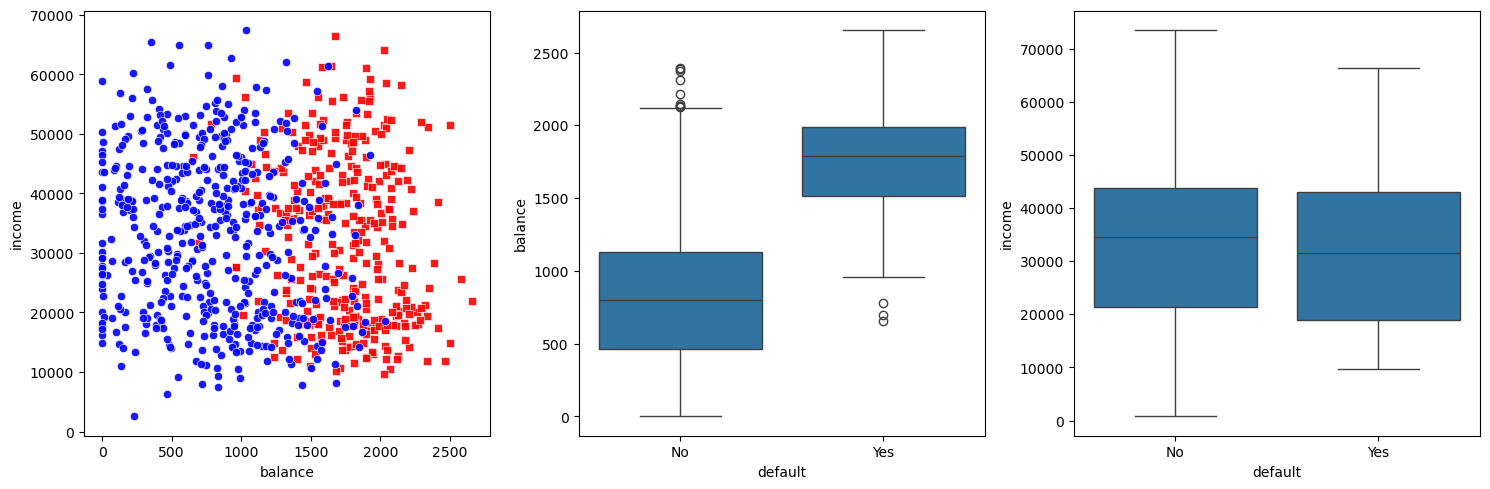

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(
    x='balance', y='income', data=df[df.default == 'Yes'], 
    marker='s', color='red', alpha=0.9, ax=ax1
    )
sns.scatterplot(
    x='balance', y='income', data=df[df.default == 'No'].sample(500), 
    marker='o', color='blue', alpha=0.9, ax=ax1
    )
sns.boxplot(x='default', y='balance', data=df, ax=ax2)
sns.boxplot(x='default', y='income', data=df, ax=ax3)
fig.tight_layout();

### 1.2 Klasyfikacja za pomocą regresji liniowej?

1. Jeśli zmienna celu ma więcej niż dwie wartości, to kodowanie tej zmiennej za pomocą liczb całkowitych wymusza porządek na kategoriach. Jednak naturalny porządek w kategoriach nie musi istnieć, co prowadzi do problemów interpretacyjnych.
2. Regresja liniowa ma wartości w całym zbiorze liczb rzeczywistych, więc może przewidywać wartości spoza zakresu zmiennej celu. Często chcemy, aby funkcja wyznaczona przez model mogła być interpretowana jako prawdopodobieństwo, co ogranicza jej zakres wartości do przedziału $[0,1]$.
3. Minimalizacja błędu średniokwadratowego w klasyfikacji nie prowadzi do estymatora o dobrych właściwościach decyzyjnych. W szczególności funkcja kosztu MSE nie jest dobrze dopasowana do problemów z dwiema klasami: jest mało wrażliwa na błędy w obszarach, gdzie prawdopodobieństwa są skrajne, oraz karze liniowo odchylenia od etykiet 0/1, co nie odpowiada logarytmicznej strukturze błędu probabilistycznego.

### 1.3 Model regresji logistycznej

Niech zmienna celu $Y\in\{0,1\}$ będzie dwuklasową zmienną losową, a $X$ wektorem losowym zmiennych objaśniających. 
Jeśli dla każdego $x$ znany jest rozkład $Y\mid X=x$, to możemy skonstruować klasyfikator Bayesa $f^*$, który jest klasyfikatorem o najmniejszym możliwym oczekiwanym błędzie predykcji

\begin{equation*}
\operatorname{EPE}(f^*)=E\left(I(Y\ne f^*(X))\right).
\end{equation*}

Klasyfikator ten przypisuje $x$ do tej klasy, która ma najwyższe prawdopodobieństwo. W przypadku klasyfikacji binarnej z $Y$ o wartościach w $\{0,1\}$:

\begin{equation*}
f^*(x)= \operatorname{argmax}_{i=0,1}P(Y=i\mid X=x)
\end{equation*}

Niestety, rozkład $Y\mid X=x$ na ogół jest nieznany. Dlatego budowa modelu klasyfikacyjnego często polega na aproksymacji tego rozkładu. Gdy aproksymacja jest znana, to klasyfikator budowany jest tak jak klasyfikator Bayesa, z wykorzystaniem aproksymujących rozkładów.

Regresja logistyczna przyjmuje w tym celu prostą, strukturalną postać aproksymacji. Ponieważ klasy są dwie, wystarczy określić jedno prawdopodobieństwo, np. $P(Y=1\mid X=x)$. Zamiast modelować je bezpośrednio, wprowadza się logit — logarytm ilorazu szans zdarzenia $Y=1$ względem $Y=0$. Funkcja logitowa wprowadza odwracalne przekształcenie przedziału prawdopodobieństw $(0,1)$ na prostą $ \mathbb{R}$. Regresja logistyczna wykorzystuje ten fakt zakładając, że logit ma postać liniową względem $x$:


<div class="wzor">

\begin{equation*}
\log\left(\frac{P(Y=1|X=x)}{1-P(Y=1|X=x)}\right) = \beta_0+\beta_1x_1+\dots+\beta_px_p.
\end{equation*}

</div>

Ponieważ logity mają wartości w całym zbiorze liczb rzeczywistych, a nie tylko w przedziale $(0,1)$ jak prawdopodobieństwa, więc modelowanie logitów za pomocą funkcji liniowej jest dużo bardziej odpowiednie niż modelowanie samych prawdopodobieństw.

To założenie prowadzi do reprezentacji prawdopodobieństwa za pomocą funkcji sigmoidalnej:


<div class="wzor">

\begin{equation*}
\begin{split}
P(Y=1|X=x) &= \frac{\exp(\beta_0+\beta_1x_1+\dots+\beta_px_p)}{1+\exp(\beta_0+\beta_1x_1+\dots+\beta_px_p)} \\
&= \frac{1}{1+\exp(-(\beta_0+\beta_1x_1+\dots+\beta_px_p))} \\
&= \sigma(\beta_0+\beta_1x_1+\dots+\beta_px_p),
\end{split}
\end{equation*}
</div>



gdzie


<div class="wzor">

\begin{equation*}
\sigma(a) = \frac{1}{1+\exp(-a)},\quad a\in\mathbb{R}.
\end{equation*}
</div>

Parametry $\beta_0,\beta_1,\dots,\beta_p$ są nieznane; szacujemy je, zwykle stosując metodę największej wiarygodności.

Funkcja $\sigma$ jest funkcją rosnącą, przyjmuje wartości z przedziału $(0,1)$ i jest symetryczna względem $a=0$.

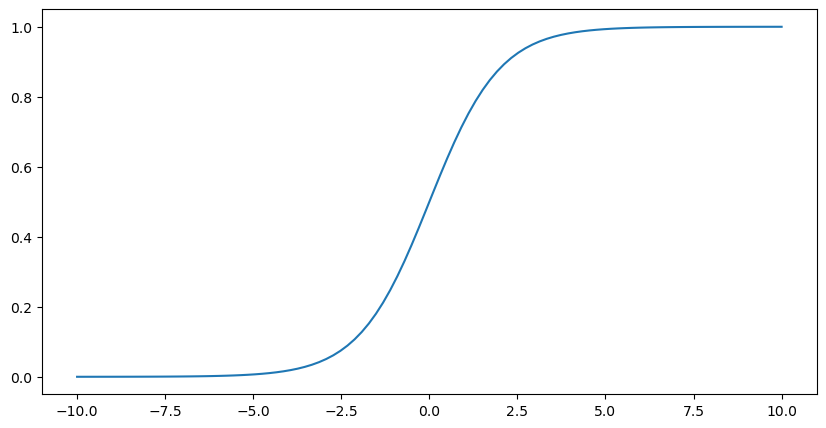

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fig = plt.figure(figsize=(10, 5))
x = np.linspace(-10, 10, 100)
sns.lineplot(x=x, y=sigmoid(x));

### 1.4 Regresja logistyczna jednowymiarowa

Załóżmy, że $X$ jest zmienną losową o wartościach w $\mathbb{R}$. Wówczas model przyjmuje postać:


<div class="wzor">

\begin{equation}
\begin{split}
P(Y=1|X=x) &= \frac{\exp(\beta_0+\beta_1x)}{1+\exp(\beta_0+\beta_1x)}\\
&= \frac{1}{1+\exp(-(\beta_0+\beta_1x))}\\
&= \sigma(\beta_0+\beta_1x).
\end{split}\tag{logit model}
\end{equation}
</div>



Przykładowo, kodując zmienną `default` jako `No`$=0$, `Yes`$=1$ i wykorzystując `balance` jako zmienną objaśniającą, model regresji logistycznej szacuje prawdopodobieństwo zalegania z płatnościami pod warunkiem wystąpienia określonego salda `balance`:

\begin{equation*}
P(\verb+default+ = \verb+Yes+ | \verb+balance+).
\end{equation*}

Obserwację przypiszemy do klasy `Yes`, jeśli szacowane prawdopodobieństwo jest większe niż $.5$; w przeciwnym przypadku przypiszemy obserwację do klasy `No`. Jest to postępowanie, które próbuje aproksymować klasyfikator Bayesa. 

Przykład dla zmiennej `default` względem `balance`:

In [8]:
X = df[['balance']]
y = df.default.map({'Yes': 1, 'No': 0})
logit = sm.Logit(y, sm.add_constant(X))
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


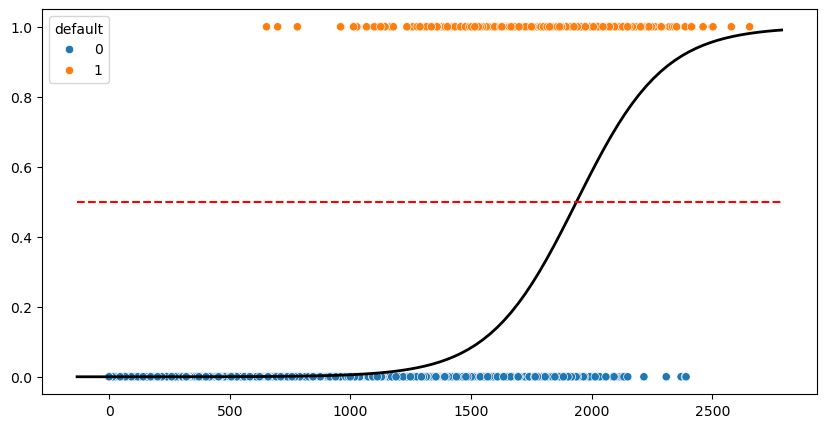

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=X.values.reshape(-1), y=y.values, hue=y, ax=ax)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
ax.plot(x, result.predict(sm.add_constant(x)), color='black', linewidth=2)
ax.hlines(0.5, xmin, xmax, color='red', linestyle='--');

### 1.5 Predykcje

Zobaczmy jaka jest szansa zalegania z płatnościami dla klienta o saldzie `balance`$=1800$:

In [8]:
[p] = result.predict([1, 1800])
p, p / (1 - p)

(np.float64(0.3201069956070024), np.float64(0.4708196635922016))

Widzimy, że $P(\verb+default+ = \verb+Yes+ | \verb+balance+ = 1800) = .32$. Zatem szansa na zaleganie z płatnościami wynosi $0.32/(1-0.32)\approx 0.5=1:2$, czyli jeden na trzech klientów.

Wiele aspektów modelu logistycznego jest analogicznych do modelu liniowego. Oto tabela parametrów dla prawdobodobieństwa `default`$=1$ (czyli `Yes`) pod warunkiem `balance`:

In [9]:
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


W kolumnie `z` widzimy wartości statystyki $Z$. Dla współczynnika $\beta_1$ jest ona równa $\hat{\beta}_1/SE(\hat{\beta}_1)$, gdzie $SE(\hat{\beta}_1)$ jest estymatorem odchylenia standardowego $\hat{\beta}_1$. Statystyka $Z$ jest testowana przeciw hipotezie zerowej $H_0:\beta_1=0$. Mała wartość $p$-value pozwala na odrzucenie hipotezy zerowej na rzecz alternatywnej $H_1:\beta_1\neq 0$. Hipoteza alternatywna mówi, że etykieta $Y$ zależy od zmiennej $X$. W naszym przypadku $p$-value jest bardzo małe, co pozwala na odrzucenie hipotezy zerowej. Zatem zmienna `default` zależy od zmiennej `balance`.

Jak zinterpretować współczynnik `balance`? Zgodnie z modelem logistycznym, wzrost `balance` o jednostkę powoduje wzrost logitu o $\hat{\beta}_1=0.0055$. Zatem szansa zalegania z płatnościami ulega **wymnożeniu** przez $\exp(0.0055)\approx 1.0055$. Zatem wzrost `balance` o jednostkę powoduje wzrost szansy wystąpienia `default` o $0.55\%$.

### Predykcje

Z podanej wyżej tabeli wnioskujemy, że

\begin{equation*}
\begin{split}
\hat{P}(\texttt{default} = \texttt{Yes} | \texttt{balance}) &= \sigma(-10.6513+0.0055\cdot\texttt{balance})\\
&= \frac{1}{1+\exp(-(-10.6513+0.0055\cdot\texttt{balance}))}.
\end{split}
\end{equation*}

Zatem dla `balance`$=1000$:

\begin{equation*}
\hat{P}(\texttt{default} = \texttt{Yes} | \texttt{balance} = 1000) = \frac{1}{1+\exp(-(-10.6513+0.0055\cdot 1000))} = 0.0058.
\end{equation*}

Zatem szansa zalegania z płatnościami dla klienta o saldzie `balance`$=1000$ wynosi $0.58\%$, czyli jest bardzo mała. Dla `balance`$=2000$ to prawdopodobieństwo jest znanacznie większe:

\begin{equation*}
\hat{P}(\texttt{default} = \texttt{Yes} | \texttt{balance} = 2000) = \frac{1}{1+\exp(-(-10.6513+0.0055\cdot 2000))} = 0.586,
\end{equation*}

czyli około $59\%$.

Te same predykcje można uzyskać za pomocą metody `predict`:

In [10]:
result.predict([1, 1000])

array([0.00575215])

In [11]:
result.predict([1, 2000])

array([0.58576937])

Podobnie jak w przypadku regresji liniowej, również i w regresji logistycznej predyktor może być zmienną jakościową. 

Przykład modelu szacującego prawdobodobieństwo wystąpienia `default` pod warunkiem `student`:

In [12]:
y = df.default.map({'Yes': 1, 'No': 0})
X = df.student.map({'Yes': 1, 'No': 0})
logit = sm.Logit(y, sm.add_constant(X))
result = logit.fit()
result.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student,0.4049,0.115,3.520,0.000,0.179,0.630


$p$-wartość dla współczynnika `student` jest bardzo mała, co pozwala na odrzucenie hipotezy zerowej $H_0:\beta_1=0$ na rzecz hipotezy alternatywnej $H_1:\beta_1\neq 0$. Zatem zmienna `default` zależy od zmiennej `student`. Współczynnik $\beta_1$ jest dodatni, co oznacza, że szansa zalegania z płatnościami jest większa dla studentów niż dla nie-studentów. Konkretne prawdopobieństwa są następujące:

\begin{equation*}
\begin{split}
\hat{P}(\texttt{default} = \texttt{Yes} | \texttt{student} = \texttt{Yes}) &= \sigma(-3.5041+0.4049\cdot 1)\\
&= \frac{1}{1+\exp(-(-3.5041+0.4049))} = 0.0431,
\end{split}
\end{equation*}

oraz 

\begin{equation*}
\begin{split}
\hat{P}(\texttt{default} = \texttt{Yes} | \texttt{student} = \texttt{No}) &= \sigma(-3.5041+0.4049\cdot 0)\\
&= \frac{1}{1+\exp(-(-3.5041))} = 0.0292.
\end{split}
\end{equation*}

In [13]:
result.predict([1, 1])

array([0.04313859])

In [14]:
result.predict([1, 0])

array([0.02919501])

### 1.6 Regresja logistyczna wielowymiarowa

Model logistyczny prawdobodobieństwa `default`$=1$ pod warunkiem `balance`, `income` i `student`:

In [10]:
y = df.default.map({'Yes': 1, 'No': 0})
X = df[['balance', 'income']].copy()
X['student'] = df.student.map({'Yes': 1, 'No': 0})
logit = sm.Logit(y, sm.add_constant(X))
result = logit.fit()
result.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


Zauważmy, że teraz, przeciwnie niż w poprzednim modelu, współczynnik `student` jest ujemny. Czyli poprzednio uzyskaliśmy wniosek, że wśród studentów szansa na zaleganie z płatnościami jest większa niż wśród nie-studentów, podczas gdy teraz uzyskujemy wniosek odwrotny. Fakt ten jest spowodowany tym, że zmienna `balance` częściowo tłumaczy tak zmienną `student`, jak i `default`: wzrost `balance` powoduje wzrost prawdopodobieństwa na zaleganie z płatnościami i jednocześnie wzrost prawdopodobieństwa bycia studentem. Zmienna `balance` jest *zmienną zakłócającą* (*confounding variable*) wprowadzającą pozorną zależność między `student` a `default`. Zależność ta udaje się wyjaśnić dopiero po wprowadzeniu zmiennej `balance` do modelu.

Obliczmy prawdobodobieństwa wystąpienia `default` dla klienta o saldzie `balance`$=2000$, dochodzie `income`$=50000$ i będącego studentem:

<!-- \begin{equation*}
\begin{split}
\hat{P}(\verb+default+ = \verb+Yes+ |& \verb+balance+ = 2000, \verb+income+ = 50000, \verb+student+ = \verb+Yes+)\\ &= \sigma(-10.8690+0.0057\cdot 2000+0.0000\cdot 50000-0.6468\cdot 1)\\
&= \frac{1}{1+\exp(-(-10.8690+0.0057\cdot 2000+0.0000\cdot 50000-0.6468\cdot 1))} = 0.53.
\end{split}
\end{equation*} -->

\begin{equation*}
\begin{split}
\hat{P}(\texttt{default} = \texttt{Yes} |& \texttt{balance} = 2000, \texttt{income} = 50000, \texttt{student} = \texttt{Yes})\\ &= \sigma(-10.8690+0.0057\cdot 2000+0.0000\cdot 50000-0.6468\cdot 1)\\
&= \frac{1}{1+\exp(-(-10.8690+0.0057\cdot 2000+0.0000\cdot 50000-0.6468\cdot 1))} = 0.53.
\end{split}
\end{equation*}

In [16]:
result.predict([1, 2000, 50000, 1])

array([0.52718866])

### 1.7 Estymacja parametrów

Dla uproszczenia pokażemy estymację parametrów na przykładzie regresji logistycznej z jedną zmienną objaśniającą. W przypadku postępowanie przebiega analogicznie.

Zwykle w modelu regresji logistycznej parametry $\beta_0$ i $\beta_1$ szacuje się metodą największej wiarygodności. W tym przypadku metoda ta przyjmuje następującą postać. Ustalmy parę $(\beta_0,\beta_1)\in\mathbb{R}^2$ i rozważmy prawdopobieństwo warunkowe

\begin{equation*}
P(Y_1=y_1,\dots,Y_n=y_n|X_1=x_1,\dots,X_n=x_n;\beta_0,\beta_1),
\end{equation*}

gdzie $(x_i,y_i)$, $i=1,\dots,n$ są obserwacjami ze zbioru uczącego.

Poszukujemy takich parametrów $\hat\beta_0$, $\hat\beta_1$, dla których prawdopodobieństwo to jest maksymalne. Można myśleć, że będą to parametry, dla których obserwowane dane są w tym modelu najbardziej prawdopodobne. Funkcję

<div class="wzor">

\begin{equation*}
\ell(\beta_0,\beta_1) = P(Y_1=y_1,\dots,Y_n=y_n|X_1=x_1,\dots,X_n=x_n;\beta_0,\beta_1)
\end{equation*}
</div>

nazywamy *funkcją wiarygodności* (*likelihood function*). Jeśli obserwacje są niezależne, to podany wyżej warunkowy rozkład łączny można zapisać jako iloczyn rozkładów warunkowych:

<div class="wzor">

\begin{equation*}
\begin{split}
\ell(\beta_0,\beta_1) &= P(Y_1=y_1,\dots,Y_n=y_n|X_1=x_1,\dots,X_n=x_n;\beta_0,\beta_1)\\
&= \prod_{i:y_i=1} \sigma(\beta_0+\beta_1x_i)\prod_{i:y_i=0} (1-\sigma(\beta_0+\beta_1x_i))\\
&= \prod_{i=1}^n \sigma(\beta_0+\beta_1x_i)^{y_i} (1-\sigma(\beta_0+\beta_1x_i))^{1-y_i}.
\end{split}
\end{equation*}

</div>

Jeśli dane $x_i$ nie są liniowo separowalne (w przypadku jednowymiarowym oznacza to brak liczby rozdzielającej wartości z obu klas), to funkcja $\ell(\beta_0,\beta_1)$ jest wypukła i posiada dokładnie jedno maksimum lokalne $(\hat\beta_0,\hat\beta_1)$, które jest równocześnie maksimum globalnym. Wówczas $(\hat\beta_0,\hat\beta_1)$ są szukanymi estymatorami parametrów $\beta_0$, $\beta_1$. Maksimum to wyznacza się numerycznie metodą Newtona-Raphsona lub metodą gradientu prostego.

### 1.8 Ocena jakości modelu

Do oceny jakości modelu regresji logistycznej (i ogólnie modeli klasyfikacyjnych) stosuje się różne miary, takie jak macierz pomyłek, dokładność (accuracy), precyzję (precision), czułość (recall), swoistość (specificity) oraz krzywą ROC i pole pod krzywą (AUC).

Poniżej zdefiniujemy te wielkości na przykładzie regresji logistycznej zastosowanej do zbioru `Default`. Miary obliczymy na zbiorze treningowym, otrzymamy więc przesadnie optymistyczne wyniki. Z drugiej jednak strony regresja logistyczna jest dość "sztywnym" modelem: ma liniową granicę decyzyjną i tyle parametrów ile cech. Czyni ją to nieco podobną do regresji liniowej, więc przeuczenie (overfitting) nie powinno być zbyt duże.  

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
y_pred = (result.predict(sm.add_constant(X)) >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred)
cm

array([[9627,   40],
       [ 228,  105]])

In [19]:
(cm[0, 0] + cm[1, 1]) / cm.sum() # dokładność (accuracy) klasyfikatora na zbiorze treningowym

np.float64(0.9732)

<!-- array([[9627,   40],
       [ 228,  105]]) -->
Powyższa macierz jest *macierzą pomyłek* (*confusion matrix*). Wiersze odpowiadają prawdziwym klasom, kolumny klasom przewidywanym. Element $(i,j)$ macierzy to liczba obserwacji klasy $i$, które zostały zaklasyfikowane do klasy $j$. W idealnym klasyfikatorze macierz ta byłaby macierzą diagonalną.

Zatem:
* 9627 osób nie zaciągnęło kredytu i zostało zaklasyfikowanych do klasy "niezaciągających kredytu"; prawdziwie ujemna (TN, *true negative*): klasyfikator poprawnie przewidział, że cecha nie wystąpi;
* 40 osób nie zaciągnęło kredytu, ale zostało zaklasyfikowanych do klasy "zaciągających kredyt"; fałszywie dodatnia (FP, *false positive*): klasyfikator błędnie przewidział, że cecha wystąpi;
* 228 osób zaciągnęło kredyt i zostało zaklasyfikowanych do klasy "niezaciągających kredytu"; fałszywie ujemna (FN, *false negative*): klasyfikator błędnie przewidział, że cecha nie wystąpi;
* 105 osób zaciągnęło kredyt i zostało zaklasyfikowanych do klasy "zaciągających kredyt"; prawdziwie dodatnia (TP, *true positive*): klasyfikator poprawnie przewidział, że cecha wystąpi.

<!-- <!-- array([[9627,   40],
       [ 228,  105]]) -->
Macierz pomyłek można wykorzystać do obliczenia wielu miar jakości klasyfikatora. Przykładowo:
* *accuracy* (dokładność) - stosunek liczby poprawnych klasyfikacji do liczby wszystkich klasyfikacji: $(TP+TN)/(TP+TN+FP+FN)$; w naszym przypadku: $(9627+105)/(9627+40+228+105) = 0.9732$; odpowiada na pytanie: jak często klasyfikator poprawnie przewiduje klasę obserwacji;
* *specificity* (swoistość) - stosunek liczby klasyfikacji prawdziwie ujemnych do liczby wszystkich obserwacji ujemnych: $TN/(TN+FP)$; w naszym przypadku: $9627/(9627+40) = 0.9959$; odpowiada na pytanie: jak często klasyfikator poprawnie przewiduje w klasie ujemnej;
* *recall* (czułość, *sensitivity*) - stosunek liczby klasyfikacji prawdziwie dodatnich do liczby wszystkich obserwacji dodatnich: $TP/(TP+FN)$; w naszym przypadku: $105/(105+228) = 0.3153$; odpowiada na pytanie: jak często klasyfikator poprawnie przewiduje w klasie dodatniej;
* *precision* (precyzja) - stosunek liczby klasyfikacji prawdziwie dodatnich do liczby wszystkich klasyfikacji dodatnich: $TP/(TP+FP)$; w naszym przypadku: $105/(105+40) = 0.7241$; odpowiada na pytanie: jak często przewidywania klasy dodatniej są poprawne;

Rozważmy test, który ma na celu wykrycie choroby. Załóżmy, że wynik pozytywny wskazuje na obecność choroby, negatywny na jej brak. Wówczas:
* **dokładność** odpowiada na pytanie: jak często test poprawnie przewiduje obecność lub brak choroby;
* **swoistość** odpowiada na pytanie: jak często wśród osób zdrowych test poprawnie przewiduje brak choroby;
* **czułość** odpowiada na pytanie: jak często wśród osób chorych test poprawnie przewiduje obecność choroby;
* **precyzja** odpowiada na pytanie: jak często pozytywny wynik testu jest poprawny.

#### Zadanie

Założmy, że mamy test na obecność choroby, który ma swoistość 0.99 i czułość 0.95. W populacji 1% osób choruje. Jakie jest prawdopodobieństwo, że osoba z pozytywnym wynikiem testu jest chora?

**Rozwiązanie.** Niech $D$ oznacza obecność choroby, a $T$ pozytywny wynik testu. Szukamy $P(D|T)$. Mamy:

\begin{align*}
P(D) &= 0.01,\\
P(T|D) &= 0.95,\\
P(T|\neg D) &= 1-0.99 = 0.01.
\end{align*}

Z twierdzenia Bayesa:

\begin{equation*}
P(D|T) = \frac{P(T|D)P(D)}{P(T)}.
\end{equation*}

Z twierdzenia o prawdopodobieństwie całkowitym:

\begin{equation*}
P(T) = P(T|D)P(D) + P(T|\neg D)P(\neg D).
\end{equation*}

Zatem:

\begin{equation*}
\begin{split}
P(D|T) &= \frac{P(T|D)P(D)}{P(T|D)P(D) + P(T|\neg D)P(\neg D)}\\
&= \frac{0.95\cdot 0.01}{0.95\cdot 0.01 + 0.01\cdot 0.99}\approx 0.49.
\end{split}
\end{equation*}

Zatem, mimo że test ma wysoką czułość i swoistość, to w przypadku niskiej częstości występowania choroby, pozytywny wynik testu nie jest mocnym argumentem za obecnością choroby - test ma niską precyzję.

---



<!-- <!-- array([[9627,   40],
       [ 228,  105]]) -->
Widzimy, że nasz model ma bardzo wysoką dokładność i swoistość. Oznacza to, że przeważająca liczba obserwacji została poprawnie zaklasyfikowana oraz, że w klasie ujemnej (niezaciągających kredytu) przeważająca liczba obserwacji również została poprawnie zaklasyfikowana. Niestety, naiwny model przewidujący "niezaciąganie kredytu" dla wszystkich obserwacji ma dokładność $9667/10000=0.9667$, a swoistość 1 (nie popełnia żadnych błędów w klasie ujemnej). Zatem nasz model jest tylko nieznacznie lepszy od naiwnego modelu. Powodem tego stanu rzeczy jest nierównomierna liczba obserwacji w klasach. W zbiorze uczącym jest 9667 obserwacji klasy "niezaciągających kredytu" i tylko 333 obserwacje klasy "zaciągających kredyt". 

Precyzja równa 0.7241 oznacza, że jeśli model przewiduje, że osoba zaciągnie kredyt, to w 72.41% przypadków jego przewidywanie jest poprawne. Czułość równa 0.3153 oznacza, że jeśli osoba zaciągnie kredyt, to jedynie w 31.53% przypadków model to poprawnie przewidzi. Oznacza to, że wśród osób, które zaciągnęły kredyt, model myli się w 68.47% przypadków, a zatem bardzo często.
W praktyce, w zależności od celu klasyfikacji, możemy chcieć zwiększyć precyzję kosztem czułości lub odwrotnie zmieniając próg decyzyjny. 

Przykładowo, dla progu $0.2$ obserwację $X=x$ przypisujemy do klasy "zaciągających kredyt", gdy

\begin{equation*}
P(\text{default}=\text{"Yes"}|X=x) > 0.2.
\end{equation*}

Otrzymujemy wówczas macierz pomyłek:

In [20]:
threshold = 0.2
y_pred = result.predict(sm.add_constant(X)) > threshold
confusion_matrix(y, y_pred)

array([[9390,  277],
       [ 130,  203]])

Teraz liczba poprawnych przewidywań w klasie dodatniej jest równa $203/(130+203)=0.609$, czyli 61% (wcześniej było to 23.73%). Z drugiej strony, liczba poprawnych przewidywań w klasie ujemnej spadła do $9390/(9390+277)=0.9713$, czyli 97% (wcześniej było to 99.59%). 

Ocenę modelu dla różnych progów decyzyjnych można przedstawić na wykresie ROC: na osi odciętych znajduje się *false positive rate* (FPR, 1-swoistość), czyli klasyfikacje dodatnie w klasie ujemnej: $FPR=FP/(FP+TN)$; na osi rzędnych znajduje się *true positive rate* (TPR, czułość), czyli klasyfikacje dodatnie w klasie dodatniej: $TPR=TP/(TP+FN)$. Dla naszego modelu wykres ROC wygląda następująco (na niebiesko fragment między progiem 0.2 a 0.5):

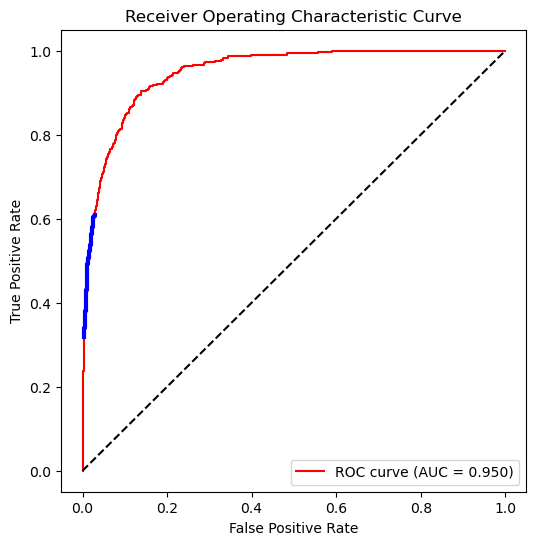

In [21]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

# fpr, tpr, thresholds = roc_curve(y, lda.predict_proba(X)[:, 1])
# auc = roc_auc_score(y, lda.predict_proba(X)[:, 1])
fpr, tpr, thresholds = roc_curve(y, result.predict(sm.add_constant(X)))
auc = roc_auc_score(y, result.predict(sm.add_constant(X)))

thr1 = 0.2
thr2 = 0.5
fpr12, tpr12 = fpr[(thr1 < thresholds) & (thresholds < thr2)], tpr[(thr1 < thresholds) & (thresholds < thr2)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {auc:.3f})')
ax.plot(fpr12, tpr12, color='blue', lw=3)
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve')
ax.legend();

Dla klasyfikatora przewidującego losowo wykres ROC jest prostą łączącą punkty $(0,0)$ i $(1,1)$. Im wykres ROC znajduje się bliżej lewego górnego rogu, tym lepszy jest klasyfikator. 

Punkt (0,0) odpowiada klasyfikatorowi przypiującemu wszystkim obserwacjom klasę ujemną. Punkt (1,1) odpowiada klasyfikatorowi przypisującemu wszystkim obserwacjom klasę dodatnią. 